# Arazi Örtüsü Uydu Görüntülerinin Sınıflandırılması
**Nesibe GÜL** N22130752
VBM 689 
Ders Dönem Projesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ham verinin görselleştirilmesi

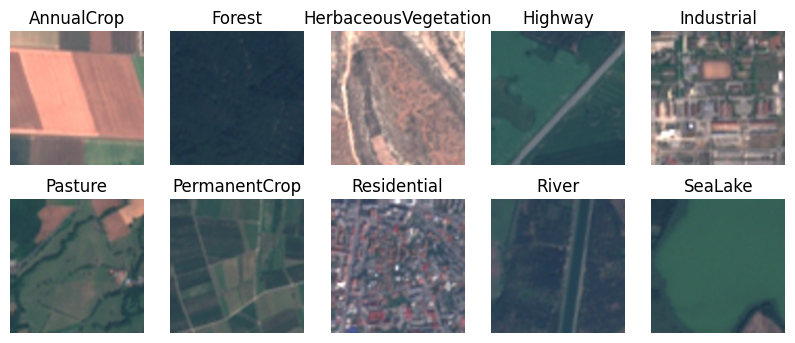

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the root directory of your test dataset
data_dir = r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/test"

# Define the list of categories in your dataset
categories = ['AnnualCrop',
              'Forest', 
              'HerbaceousVegetation', 
              'Highway', 
              'Industrial', 
              'Pasture', 
              'PermanentCrop', 
              'Residential', 
              'River', 
              'SeaLake']

# Initialize a figure object and set the size of the figure
fig = plt.figure(figsize=(10, 4))

# Loop over the categories and plot one random image from each category in a subplot
for i, category in enumerate(categories):
    # Set the path to the category directory
    category_dir = os.path.join(data_dir, category)
    # Get a list of all image files in the category directory
    image_files = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if f.endswith(('.jpg' ))]
    # Choose a random image from the category
    image_path = random.choice(image_files)
    # Open the image with PIL
    image = Image.open(image_path)
    # Resize the image to 256x256
    image = image.resize((256, 256))
    # Convert the image to a NumPy array
    image_array = np.asarray(image)
    # Add the image to the subplot
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.imshow(image_array)
    subplot.set_title(category)
    subplot.axis('off')

# Show the plot
plt.show()


## Verinin çoğaltılması (augmentation) ve normalizasyonu

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with the desired data augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Define the ImageDataGenerator for the validation set (only rescale the pixel values)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Define the ImageDataGenerator for the test set (only rescale the pixel values)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and image size for the generators
batch_size = 32
img_size = (64, 64)

# Define the directories for the training, validation, and test sets
train_dir =  r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/train"
val_dir =  r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/val"
test_dir =  r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/test"



## Flow_from_directory ile klasör isimlerinden sınıfların belirlenmesi

flow_from_directory() metodu, bir dizin yolunu belirterek klasörler içindeki görüntüleri ve etiketleri otomatik olarak yükleyebilir. batch_size parametresi ile belirtilen boyutlarda örnekler üretir. Artırılmış veri örnekleri, her bir epoch için yeniden oluşturulur ve eğitim veri setine eklenir. Bu nedenle, model eğitimi sırasında daha fazla veri örneği kullanılabilir ve aşırı öğrenme riski azaltılabilir.

In [ ]:
# generatorlerin uretilmesi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


## Sınıfların dağılımı

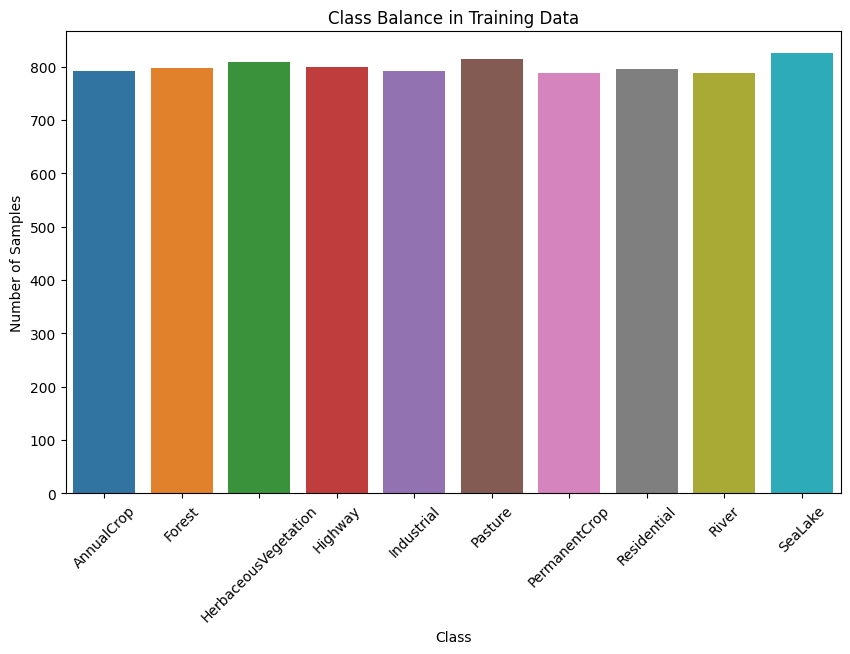

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
class_indices = train_generator.class_indices
class_indices
num_samples = []
for key in class_indices.keys():
    num_samples.append(len(train_generator.labels[train_generator.labels==class_indices[key]]))

# bar chart ile siniflarin dagilimi
plt.figure(figsize=(10,6))
sns.barplot(x=list(class_indices.keys()), y=num_samples)
plt.xticks(rotation=45)
plt.title('Class Balance in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

## Model Kütüphanelerinin İndirilmesi

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers
#regularizers
from tensorflow.keras.layers import Dropout # one of the best regularizers
from tensorflow.keras.regularizers import l1,l2,l1_l2
#optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Ftrl

# Model -1 ML Model Mimarisinin Regülasyon Yöntemleri Eklenerek Kurulması
 


In [ ]:
import tensorflow as tf

model1 = Sequential()
model1.add(Flatten(input_shape = (64,64, 3)))  
model1.add(Dense(1000,activation='relu'    ))   
model1.add(Dense(500,activation='relu', kernel_regularizer=l2(l=0.005),bias_regularizer=l2(1e-3)))  
model1.add(Dropout(rate=0.2))
model1.add(Dense(100,activation='relu' )) 
model1.add(Dense(50,activation='relu' )) 
model1.add(Dense(10,activation='softmax', kernel_regularizer=l2(l=0.005), bias_regularizer=l2(1e-2)   )) 

# early stopping
earlystopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
# ReduceLROnPlateau callback
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,min_lr = 0.0005, patience=2,verbose=1)
##Model checkpointing callback
ckpt_path = '/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/model_ckpt.h5' 
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only = True)
#List the callbacks 
callbacks=[rlronp, earlystopCB, ckpt_cb]



model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 1000)              12289000  
                                                                 
 dense_6 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               50100     
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 10)               

In [ ]:
model1.compile(optimizer="adam",loss='categorical_crossentropy' ,metrics=['accuracy' ])   


In [ ]:
history1 = model1.fit(train_generator, epochs=40, validation_data=val_generator, callbacks=callbacks)


Epoch 1/40
250/250 [==============================] - 2080s 8s/step - loss: 3.0048 - accuracy: 0.2163 - val_loss: 2.2655 - val_accuracy: 0.3110 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - 31s 125ms/step - loss: 2.1511 - accuracy: 0.3081 - val_loss: 2.0060 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - 36s 143ms/step - loss: 1.9662 - accuracy: 0.3217 - val_loss: 1.9079 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - 31s 124ms/step - loss: 1.8499 - accuracy: 0.3425 - val_loss: 1.8690 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 5/40
250/250 [==============================] - 30s 120ms/step - loss: 1.7820 - accuracy: 0.3561 - val_loss: 1.7311 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 6/40
250/250 [==============================] - 29s 117ms/step - loss: 1.7275 - accuracy: 0.3685 - val_loss: 1.6688 - val_accuracy: 0.3940 - lr: 0.0010
Epoch 7/40
250/250 [==============================] -

### MLModelin kaydedilmesi

In [ ]:
model1.save('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml1model.h5')


### En iyi modelin geriçağırma ile yeniden yüklenmesi

In [ ]:
bestmodel_checkpointcallback = tf.keras.models.load_model(ckpt_path)


### En iyi model ile test verisinde tahmin yapılması

In [ ]:
test_loss, test_acc = bestmodel_checkpointcallback.evaluate(test_generator)

32/32 [==============================] - 212s 7s/step - loss: 1.3329 - accuracy: 0.5470


### Doğruluk ve Kayıp Grafiklerinin Eğitim ve Doğrulama Veri kümeleriyle Gösterimi

In [ ]:
#Accuracy ve Loss Grafiğini Göster
def tr_plot(test_generator, tr_data, start_epoch):
    # training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    # get number of epochs and create list of epochs
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch, Epoch_count))
   
    # get best epoch based on validation loss and accuracy
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    # evaluate model on test set and get test loss and accuracy
    test_loss, test_acc = tr_data.evaluate(test_generator)
    
    # create labels for best epochs and test results
    sc_label = 'best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch = ' + str(index_acc + 1 + start_epoch)
    test_loss_label = 'test loss = {:.4f}'.format(test_loss)
    test_acc_label = 'test accuracy = {:.4f}'.format(test_acc)
    
    # create subplots for loss and accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    
    # plot training and validation loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # add test loss to the plot
    axes[0].text(Epochs[-1], test_loss, test_loss_label, ha='right', va='center', color='purple')
    
    # plot training and validation accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    # add test accuracy to the plot
    axes[1].text(Epochs[-1], test_acc, test_acc_label, ha='right', va='center', color='purple')
    
    plt.tight_layout()
    plt.show()


32/32 [==============================] - 2s 52ms/step - loss: 1.3060 - accuracy: 0.5380


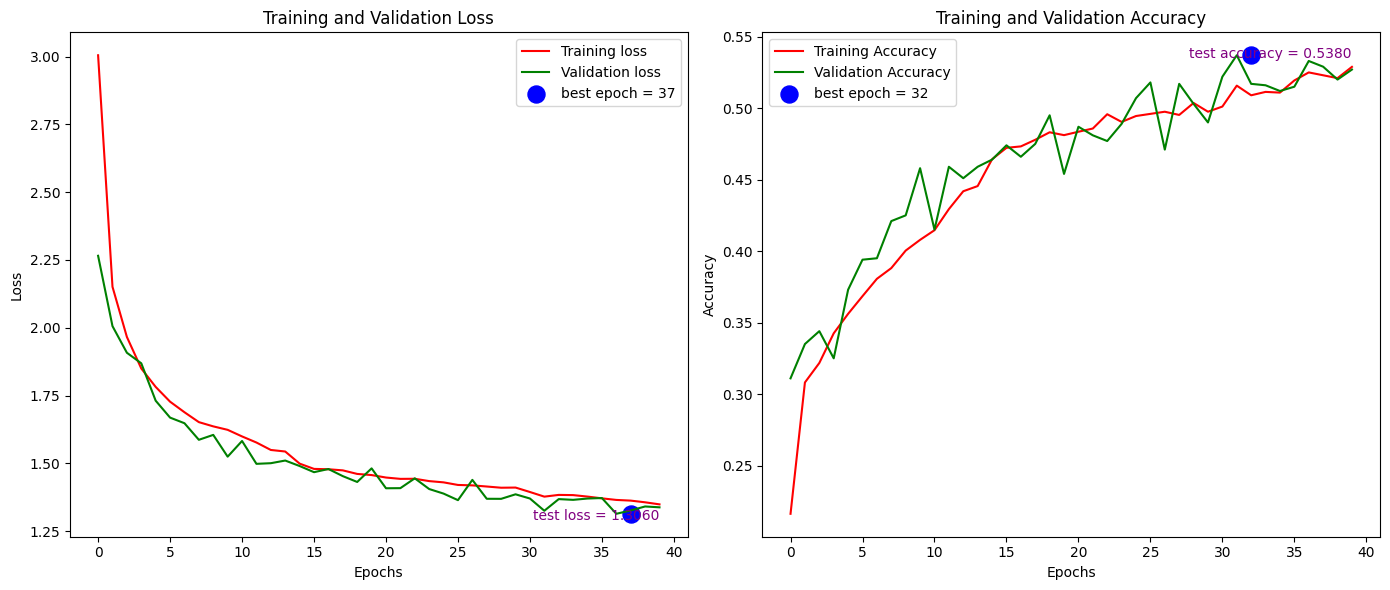

In [ ]:
    
tr_plot(test_generator, history1, 0)

### Bazı görüntülerin model tahminleri ve gerçek etiketlerinin beraber görselleştirilmesi

In [ ]:
# make predictions
def pred_real_visualize(test_dataset, model):
  # iterate over the test dataset batches
  for dataset in iter(test_dataset):
      # unpack a single batch of images and labels
      image_batch, label_batch = dataset

      # make predictions on test dataset
      y_prob = model.predict(dataset, verbose=1)

      # visualize 10 images from dataset
      plt.figure()
      for i in range(10):
          # retrieve ith image from current batch and show
          ax = plt.subplot(2, 5, i + 1)
          image = image_batch[i].numpy().astype("uint8")
          plt.imshow(image)
          plt.axis("off")  # turn off axis for clarity

          # index of highest probability indicates predicted class
          y_class = y_prob[i].argmax()
          class_indices = train_generator.class_indices

          # display image title with actual and predicted labels
          plt.title(f'Actual: {class_names[label_batch[i]][:10]},'
                    f'\nPredicted: {class_names[y_class][:10]}')

pred_real_visualize(test_generator, bestmodel_checkpointcallback)

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report

def conf_matrix(test_generator, model):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

  # iterate over the dataset
    for i, (image_batch, label_batch) in enumerate(test_generator):   # use dataset.unbatch() with repeat
      # append true labels
      y_true.append(label_batch)
      # compute predictions
      preds = model.predict(image_batch)
      # append predicted labels
      y_pred.append(np.argmax(preds, axis =  1))
      if i==300:
          break

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    correct_labels = np.argmax(correct_labels, axis=1)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    cm = confusion_matrix(correct_labels, predicted_labels)
    print(classification_report(correct_labels, predicted_labels))
    return cm

In [ ]:
conf_matrix(test_generator, bestmodel_checkpointcallback)

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.50      0.43      0.46       943
           1       0.77      0.81      0.79      1000
           2       0.39      0.33      0.36       904
           3       0.34      0.15      0.20       836
           4       0.60      0.86      0.71       972
           5       0.60      0.71      0.65       941
           6       0.47      0.41      0.44       944
           7       0.40      0.61      0.48      1070
           8       0.58      0.49      0.53      1079
           9       0.81      0.62      0.70       727

    accuracy                           0.55      9416
   macro avg       0.55      0.54      0.53      9416
weighted avg       0.54      0.55      0.53      9416



array([[407,   0,  38,  39,  54,  75, 217,  56,  57,   0],
       [ 10, 811,   0,   0,   0, 104,   0,  19,  28,  28],
       [ 76,   0, 299,  29,  92,  10, 123, 246,  19,  10],
       [ 59,  19,  47, 122,  75,  75,  47, 241, 142,   9],
       [ 36,   0,   0,   0, 836,   0,   0, 100,   0,   0],
       [ 28,  10,  55,  48,   0, 667,  10,  28,  57,  38],
       [122,   0, 192,  28,  66,  36, 387,  85,  28,   0],
       [ 59,   0, 114,  19, 185,   0,  19, 655,  19,   0],
       [ 20, 102,  29,  65,  67,  94,  19, 141, 524,  18],
       [  0, 118,   0,   9,   8,  49,   0,  67,  27, 449]])

In [ ]:
!pip install itertools
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Oran olarak confusion matrix")
    else:
        print('Confusion matrix, rakamsal olarak')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


1/1 [==============================] - 0s 108ms/step
              precision    recall  f1-score   support

           0       0.50      0.43      0.46       947
           1       0.76      0.81      0.78      1002
           2       0.39      0.33      0.36       912
           3       0.34      0.15      0.21       829
           4       0.60      0.86      0.70       977
           5       0.60      0.71      0.65       926
           6       0.48      0.42      0.45       950
           7       0.39      0.60      0.48      1063
           8       0.58      0.49      0.53      1080
           9       0.81      0.62      0.70       730

    accuracy                           0.55      9416
   macro avg       0.55      0.54      0.53      9416
weighted avg       0.54      0.55      0.53      9416

Confusion matrix, rakamsal olarak
[[408   0  39  37  56  77 214  57  59   0]
 [ 10 808   0   0   0 107   0  20  30  27]
 [ 75   0 304  30  94  10 126 246  17  10]
 [ 56  19  46 122  78  74

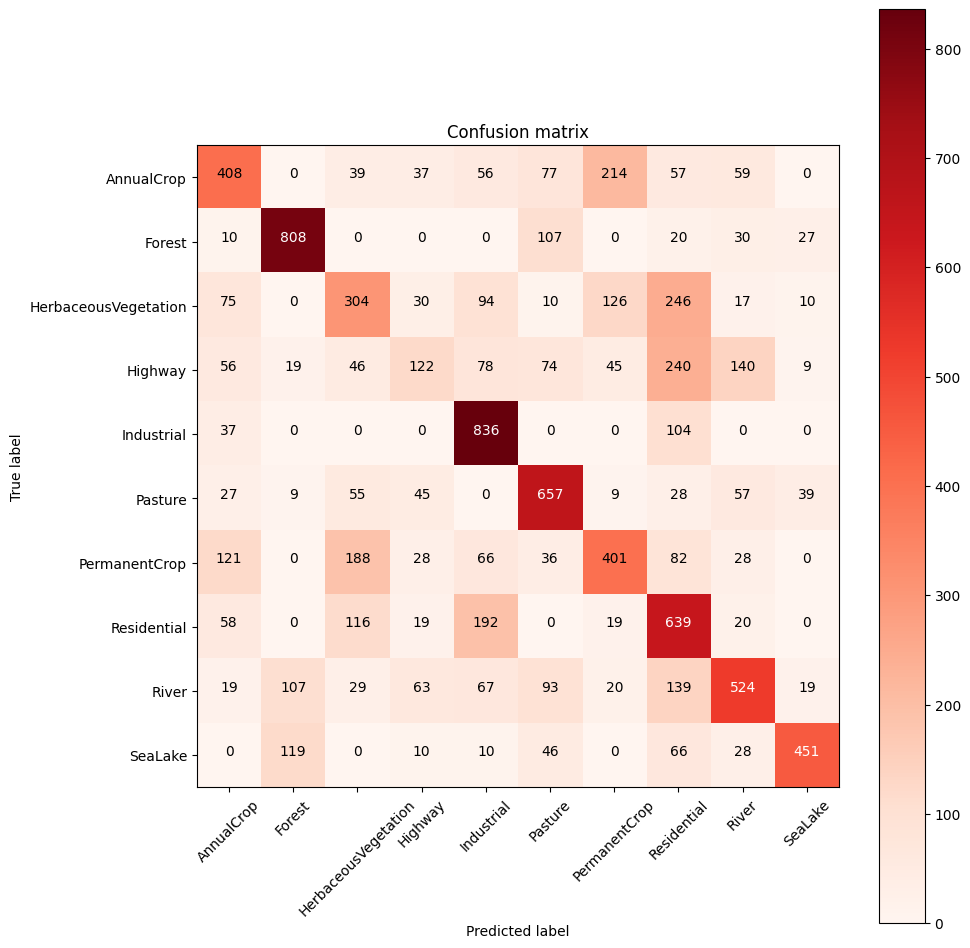

In [ ]:
## Call the function    
plot_confusion_matrix(conf_matrix(test_generator, bestmodel_checkpointcallback), test_generator.class_indices, cmap='Reds')

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.50      0.43      0.46       936
           1       0.76      0.81      0.78       993
           2       0.39      0.33      0.36       900
           3       0.34      0.15      0.21       841
           4       0.60      0.85      0.70       980
           5       0.60      0.71      0.65       927
           6       0.48      0.42      0.45       954
           7       0.39      0.61      0.48      1055
           8       0.57      0.48      0.52      1068
           9       0.81      0.61      0.70       738

    accuracy                           0.55      9392
   macro avg       0.54      0.54      0.53      9392
weighted avg       0.54      0.55      0.53      9392



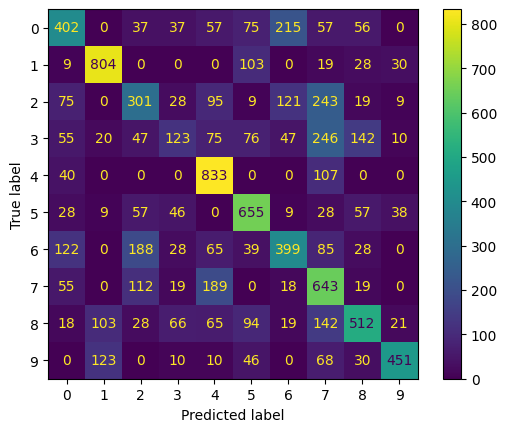

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def multi_cm(cm, test_generator, model):
    ConfusionMatrixDisplay(cm).plot()
    
multi_cm(conf_matrix(test_generator, bestmodel_checkpointcallback), test_generator, model1)

### Model mimarisinin görselleştirilmesi

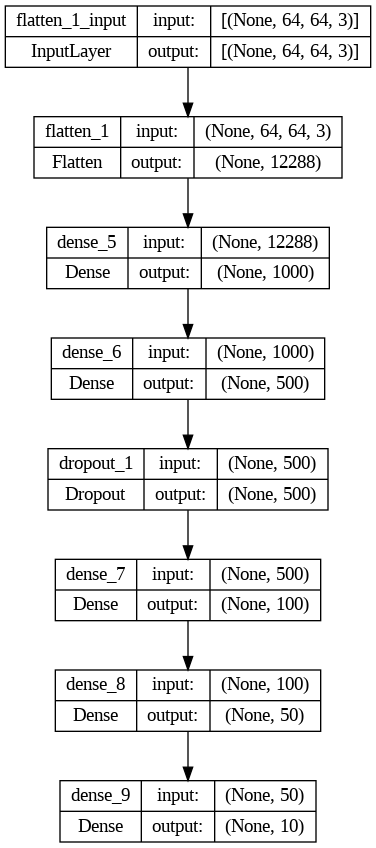

In [ ]:
tf.keras.utils.plot_model(bestmodel_checkpointcallback, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
!pip install visualkeras
import visualkeras

model = bestmodel_checkpointcallback

visualkeras.layered_view(model).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 37.9 MB/s eta 0:00:00


# Model-2  ML Model Mimarisinin Regülasyon Yöntemleri Olmadan Kurulması

In [ ]:
import tensorflow as tf

model2 = Sequential()
model2.add(Flatten(input_shape = (64,64, 3)))  
model2.add(Dense(1000,activation='relu'  ))  
model2.add(Dense(500,activation='relu'))  
model2.add(Dense(100,activation='relu'  )) 
model2.add(Dense(50,activation='relu' )) 
model2.add(Dense(10,activation='softmax')) 

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_10 (Dense)            (None, 1000)              12289000  
                                                                 
 dense_11 (Dense)            (None, 500)               500500    
                                                                 
 dense_12 (Dense)            (None, 100)               50100     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 10)                510       
                                                                 
Total params: 12,845,160
Trainable params: 12,845,160


In [ ]:
model2.compile(optimizer="adam",loss='categorical_crossentropy' ,metrics=['accuracy' ])   

In [ ]:
history2 = model2.fit(train_generator, epochs=40, validation_data=val_generator)


Epoch 1/40
250/250 [==============================] - 47s 171ms/step - loss: 2.2054 - accuracy: 0.2160 - val_loss: 1.8743 - val_accuracy: 0.2910
Epoch 2/40
250/250 [==============================] - 27s 108ms/step - loss: 1.8095 - accuracy: 0.3084 - val_loss: 1.7517 - val_accuracy: 0.3730
Epoch 3/40
250/250 [==============================] - 28s 113ms/step - loss: 1.7401 - accuracy: 0.3368 - val_loss: 1.8187 - val_accuracy: 0.3120
Epoch 4/40
250/250 [==============================] - 30s 119ms/step - loss: 1.7058 - accuracy: 0.3505 - val_loss: 1.6141 - val_accuracy: 0.3810
Epoch 5/40
250/250 [==============================] - 27s 107ms/step - loss: 1.6477 - accuracy: 0.3686 - val_loss: 1.5922 - val_accuracy: 0.4010
Epoch 6/40
250/250 [==============================] - 29s 115ms/step - loss: 1.6272 - accuracy: 0.3775 - val_loss: 1.6209 - val_accuracy: 0.4030
Epoch 7/40
250/250 [==============================] - 27s 108ms/step - loss: 1.6112 - accuracy: 0.3909 - val_loss: 1.5508 - val_ac

### Modelin Kaydedilmesi

In [ ]:
model2.save('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml2model.h5')

### Modelin geri yüklenmesi

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml2model.h5')

### Test verisiyle modelin tahmin yapması

In [ ]:
test_loss2, test_acc2 = model2.evaluate(test_generator)

32/32 [==============================] - 2s 53ms/step - loss: 1.2600 - accuracy: 0.5500


### Doğruluk kayıp değerlerinin train, validation ve test verikümesi ile gösterilmesi

32/32 [==============================] - 2s 59ms/step - loss: 1.3060 - accuracy: 0.5380


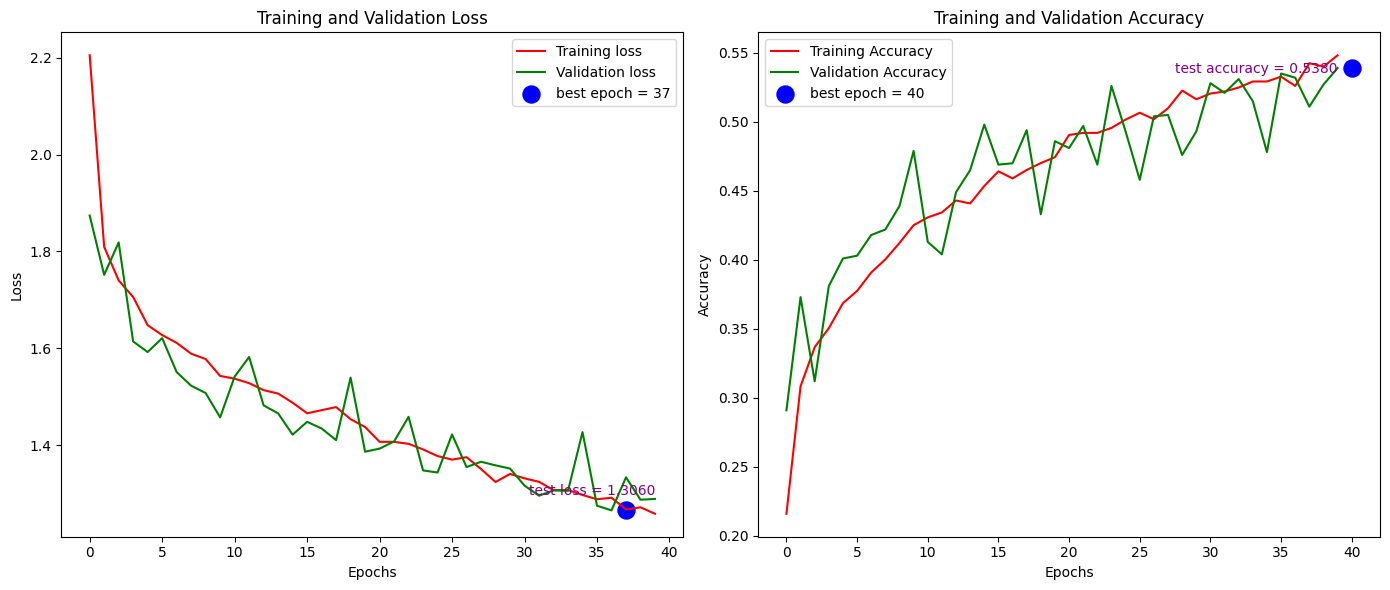

In [ ]:
tr_plot(test_generator, history2, 0)

### Confusion Matrix

1/1 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       940
           1       0.73      0.84      0.78       992
           2       0.44      0.42      0.43       905
           3       0.36      0.23      0.28       840
           4       0.74      0.71      0.73       974
           5       0.50      0.69      0.58       926
           6       0.47      0.45      0.46       947
           7       0.44      0.65      0.52      1060
           8       0.66      0.41      0.51      1072
           9       0.61      0.57      0.59       736

    accuracy                           0.55      9392
   macro avg       0.55      0.55      0.54      9392
weighted avg       0.56      0.55      0.54      9392

Confusion matrix, rakamsal olarak
[[452   0  36  64  38  49 180  56  29  36]
 [  0 834   0   0   0 121   0   9   9  19]
 [ 66   0 381  37  27  28 159 179  19   9]
 [ 20  20  83 197  47 133 

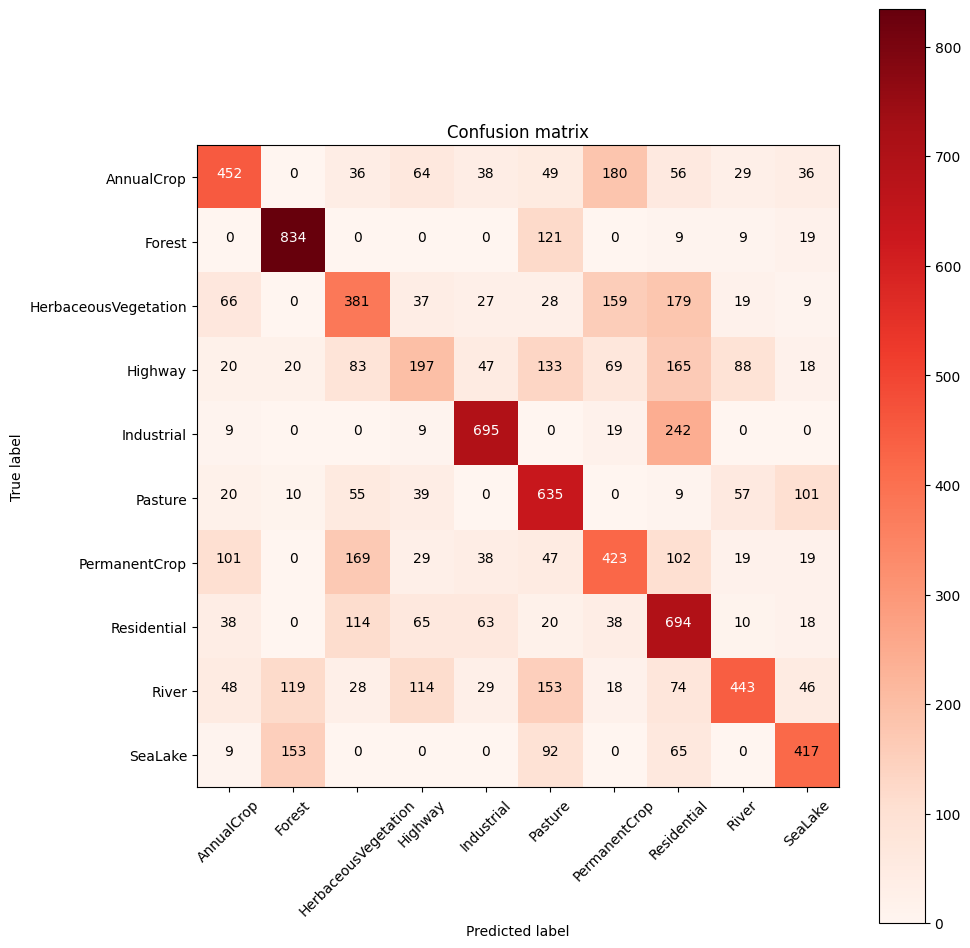

In [ ]:
cm2 = conf_matrix(test_generator, model2)
plot_confusion_matrix(cm2, test_generator.class_indices, cmap='Reds')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def multi_cm(test_generator, model):
    predictions = model.predict_generator(test_generator)
    predicted_classes = np.argmax(predictions, axis = 1)
    true_classes = test_generator.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    ConfusionMatrixDisplay(cm).plot()
    print(classification_report(true_classes, predicted_classes))
    
multi_cm(test_generator, model2)

### Model mimarisinin görselleştirilmesi

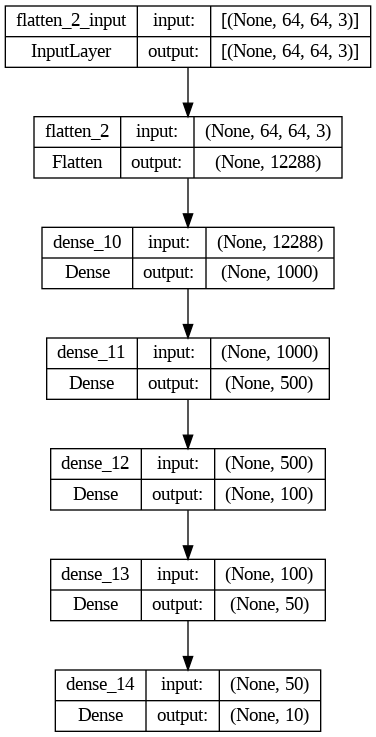

In [ ]:
tf.keras.utils.plot_model(model2, "multi_modelwithout_reg.png", show_shapes=True)

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model2).show() # display using your system viewer

visualkeras.layered_view(model2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Model-3 CNN Modeli

In [ ]:
# build tensorflow sequential convolutional neural network model
# same =  add additional row and columns to  keep 
# input shape same as input data, valid = no padding
# valid = applied to get smaller size of output

model3 = Sequential([
    # layer 1 - preprocessing layer with convolution and max pooling
    # rescaling_layer, 
    layers.Conv2D(filters=64, kernel_size=(3,3),  padding='same',
                  activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),

    # layer 2 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 3 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.2),
    
    # layer 4 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=(4,4), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.2),

    # layer 5 - convolutional layer and max pooling
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.2),
    layers.Flatten(),

    # layer 6 - dense fully connected layer
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(rate=0.2),
    # layer 7 - output dense layer
    layers.Dense(units = 10, activation = 'softmax')
])

# compile tensorflow sequential CNN model
model3.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# print model summary
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)        

### Modelin eğitilmesi

In [ ]:
history3 = model3.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
250/250 [==============================] - 30s 105ms/step - loss: 1.8719 - accuracy: 0.2575 - val_loss: 1.5318 - val_accuracy: 0.3790
Epoch 2/20
250/250 [==============================] - 28s 111ms/step - loss: 1.4189 - accuracy: 0.4414 - val_loss: 1.2336 - val_accuracy: 0.5370
Epoch 3/20
250/250 [==============================] - 26s 104ms/step - loss: 1.2007 - accuracy: 0.5552 - val_loss: 1.1981 - val_accuracy: 0.5510
Epoch 4/20
250/250 [==============================] - 28s 111ms/step - loss: 1.0636 - accuracy: 0.6024 - val_loss: 0.9712 - val_accuracy: 0.6260
Epoch 5/20
250/250 [==============================] - 26s 103ms/step - loss: 1.0166 - accuracy: 0.6236 - val_loss: 0.8430 - val_accuracy: 0.6860
Epoch 6/20
250/250 [==============================] - 26s 104ms/step - loss: 0.9385 - accuracy: 0.6559 - val_loss: 0.8665 - val_accuracy: 0.6660
Epoch 7/20
250/250 [==============================] - 26s 105ms/step - loss: 0.8751 - accuracy: 0.6790 - val_loss: 0.7979 - val_ac

### Modelin kaydedilmesi

In [ ]:
model3.save('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/cnn3model.h5')

### Modelin geri yüklenmesi

In [ ]:
model3 = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/cnn3model.h5')

### Test verisiyle modelın tahmin yapması

In [ ]:
test_loss3, test_acc3 = model3.evaluate(test_generator)

32/32 [==============================] - 2s 48ms/step - loss: 0.5063 - accuracy: 0.8150


### Doğruluk kayıp değerlerinin train, validation ve test verikümesi ile gösterilmesi

32/32 [==============================] - 2s 47ms/step - loss: 0.5063 - accuracy: 0.8150


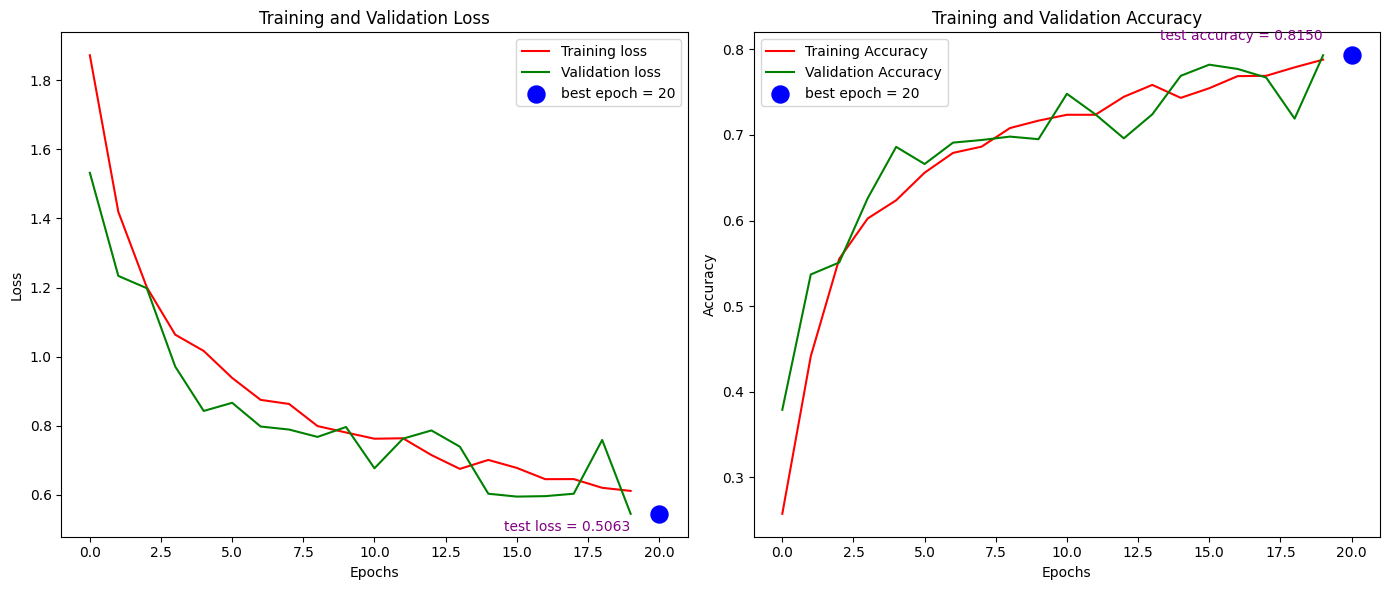

In [ ]:
# training and validation data
tacc = history3.history['accuracy']
tloss = history3.history['loss']
vacc = history3.history['val_accuracy']
vloss = history3.history['val_loss']

# get number of epochs and create list of epochs
Epoch_count = len(tacc) + 0
Epochs = list(range(0, 20))

# get best epoch based on validation loss and accuracy
index_loss = np.argmin(vloss)
val_lowest = vloss[index_loss]
index_acc = np.argmax(vacc)
acc_highest = vacc[index_acc]

# evaluate model on test set and get test loss and accuracy
test_loss, test_acc = model3.evaluate(test_generator)

# create labels for best epochs and test results
sc_label = 'best epoch = ' + str(index_loss + 1 + 0)
vc_label = 'best epoch = ' + str(index_acc + 1 + 0)
test_loss_label = 'test loss = {:.4f}'.format(test_loss)
test_acc_label = 'test accuracy = {:.4f}'.format(test_acc)

# create subplots for loss and accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# plot training and validation loss
axes[0].plot(Epochs, tloss, 'r', label='Training loss')
axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
axes[0].scatter(index_loss + 1 + 0, val_lowest, s=150, c='blue', label=sc_label)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# add test loss to the plot
axes[0].text(Epochs[-1], test_loss, test_loss_label, ha='right', va='center', color='purple')

# plot training and validation accuracy
axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
axes[1].scatter(index_acc + 1 + 0, acc_highest, s=150, c='blue', label=vc_label)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# add test accuracy to the plot
axes[1].text(Epochs[-1], test_acc, test_acc_label, ha='right', va='center', color='purple')

plt.tight_layout()
plt.show()

### Confusion matrix

1/1 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.95      0.73      0.82       942
           1       0.94      0.91      0.92       990
           2       0.66      0.72      0.69       902
           3       0.68      0.57      0.62       833
           4       0.84      0.96      0.90       981
           5       0.79      0.83      0.81       938
           6       0.64      0.65      0.65       942
           7       0.74      0.97      0.84      1063
           8       0.85      0.67      0.75      1072
           9       0.93      0.93      0.93       729

    accuracy                           0.79      9392
   macro avg       0.80      0.79      0.79      9392
weighted avg       0.80      0.79      0.79      9392

Confusion matrix, rakamsal olarak
[[ 686    0   46    0    0   37  123    0   30   20]
 [   0  896   21    0    0   45    0    0    0   28]
 [   0    0  648    0   27   10   65  133   19   

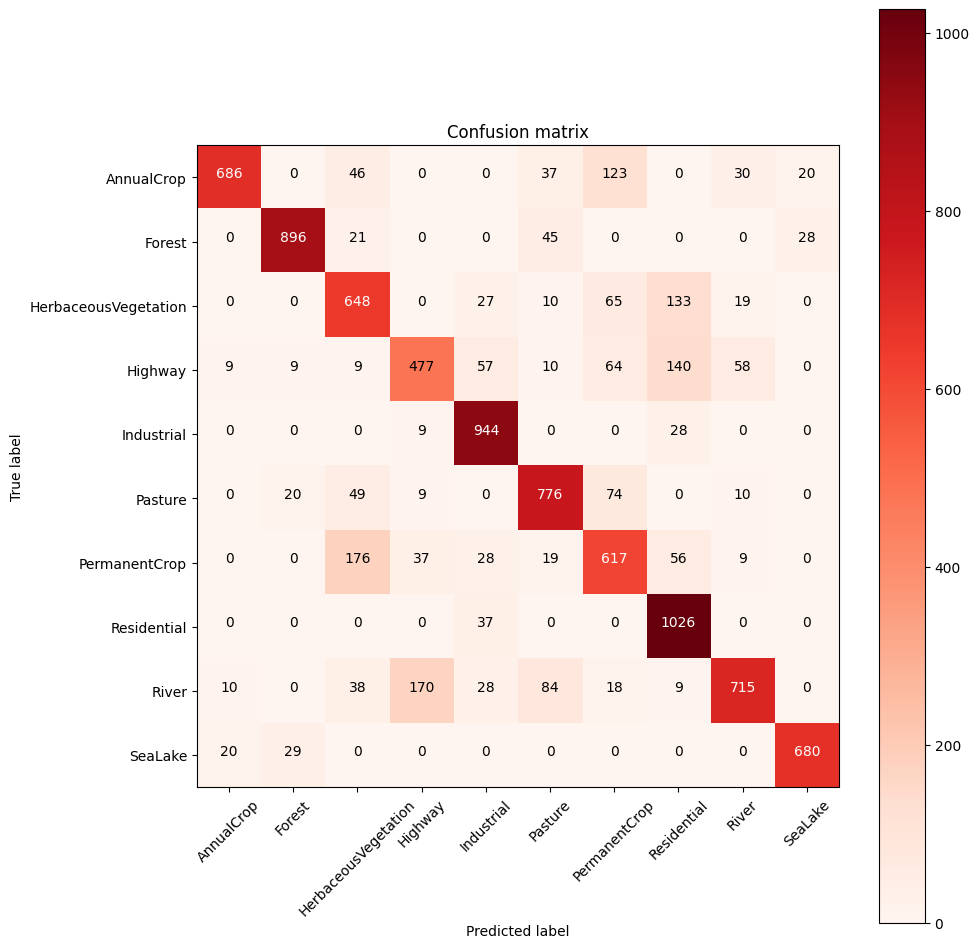

In [ ]:
cm3 = conf_matrix(test_generator, model3)
plot_confusion_matrix(cm3, test_generator.class_indices, cmap='Reds')

In [ ]:
##Bu sekilde de farklı metriklerle, precision ve recall sonuçlarını görebilirsin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
#get model predictions and plot in a confusion matrix and classification report for multicategorical models

def multi_cm(test_generator, model):
    predictions = model.predict_generator(test_generator)
    predicted_classes = np.argmax(predictions, axis = 1)
    true_classes = test_generator.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    ConfusionMatrixDisplay(cm).plot()
    print(classification_report(true_classes, predicted_classes))

multi_cm(test_generator, model3)

### Model mimarisinin görselleştrilmesi

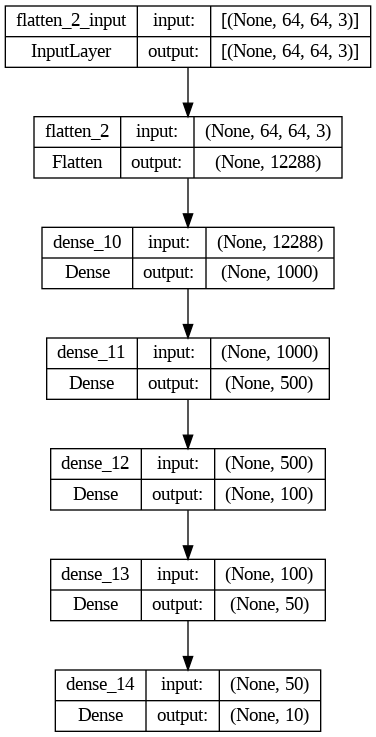

In [ ]:
tf.keras.utils.plot_model(model2, "cnn3.png", show_shapes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


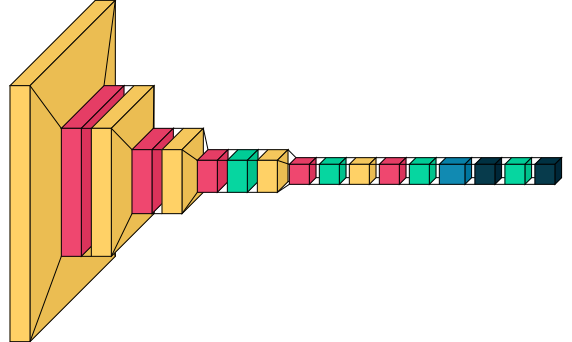

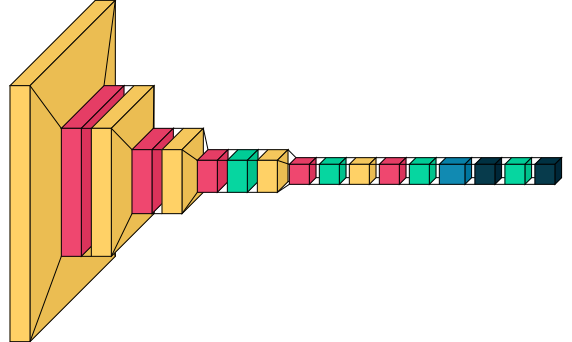

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model3).show() # display using your system viewer

visualkeras.layered_view(model3)

# Model-4 VGG19 Fine-tuning 

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# VGG19 mimarisini katsayılarıyla yükle,  full coected tabakasi hariç
model_vgg19  = VGG19(input_shape=(64, 64, 3), weights='imagenet', include_top=False)

# alexnet model mimarisi
model_vgg19 .summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# 2 evrisimli ve full-connected tabakalar disindakileri dondur
for layer in model_vgg19 .layers[:-6]:
    layer.trainable = False


model4 = Sequential(model_vgg19 )
model4.add(Flatten(input_shape=(2, 2, 512)))

# en sona fully connected katman ekle
model4.add(Dense(1000, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1000, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(10, activation='softmax'))




# yeni modelin mimarisi
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)              2049000   
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               128128    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1000)             

In [ ]:
model4.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

# Define Stopping Criteria- changed patience to 10
callbacks = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 10), 
               ModelCheckpoint(filepath='/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/model4.h5', 
                               monitor='val_accuracy', 
                               save_best_only=True, 
                               mode='max')]

### Modelin eğitilmesi

In [ ]:
# Train the model
history4 = model4.fit(train_generator, epochs=20, callbacks= callbacks, 
          validation_data=val_generator, verbose = 1)

Epoch 1/20
250/250 [==============================] - 4826s 19s/step - loss: 1.8541 - accuracy: 0.3117 - val_loss: 1.3201 - val_accuracy: 0.5300
Epoch 2/20
250/250 [==============================] - 31s 124ms/step - loss: 1.3737 - accuracy: 0.4832 - val_loss: 1.1521 - val_accuracy: 0.5660
Epoch 3/20
250/250 [==============================] - 33s 133ms/step - loss: 1.1932 - accuracy: 0.5658 - val_loss: 1.2462 - val_accuracy: 0.6020
Epoch 4/20
250/250 [==============================] - 31s 125ms/step - loss: 1.0254 - accuracy: 0.6478 - val_loss: 0.9618 - val_accuracy: 0.6710
Epoch 5/20
250/250 [==============================] - 31s 125ms/step - loss: 0.9309 - accuracy: 0.6946 - val_loss: 0.9758 - val_accuracy: 0.6780
Epoch 6/20
250/250 [==============================] - 33s 134ms/step - loss: 0.8493 - accuracy: 0.7281 - val_loss: 0.6647 - val_accuracy: 0.7940
Epoch 7/20
250/250 [==============================] - 29s 117ms/step - loss: 0.8013 - accuracy: 0.7418 - val_loss: 0.6728 - val_ac

### Modelin kaydedilmesi

In [ ]:

model4.save('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml4model.h5')

### En iyi modelin geri çağırma ile yeniden yüklenmesi

In [ ]:
ckpt_path4 = '/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml4model.h5' 
bestmodel_checkpoint4 = tf.keras.models.load_model(ckpt_path4)


### Modelin geri yüklenmesi

In [ ]:
model4 = tf.keras.models.load_model(ckpt_path4)

### Test verisiyle modelin tahmin yapması

In [ ]:
test_loss4, test_acc4 = model4.evaluate(test_generator)

32/32 [==============================] - 783s 25s/step - loss: 0.4773 - accuracy: 0.8600


### Doğruluk kayıp değerlerinin train, validation ve test verikümesi ile gösterilmesi

32/32 [==============================] - 2s 56ms/step - loss: 0.4773 - accuracy: 0.8600


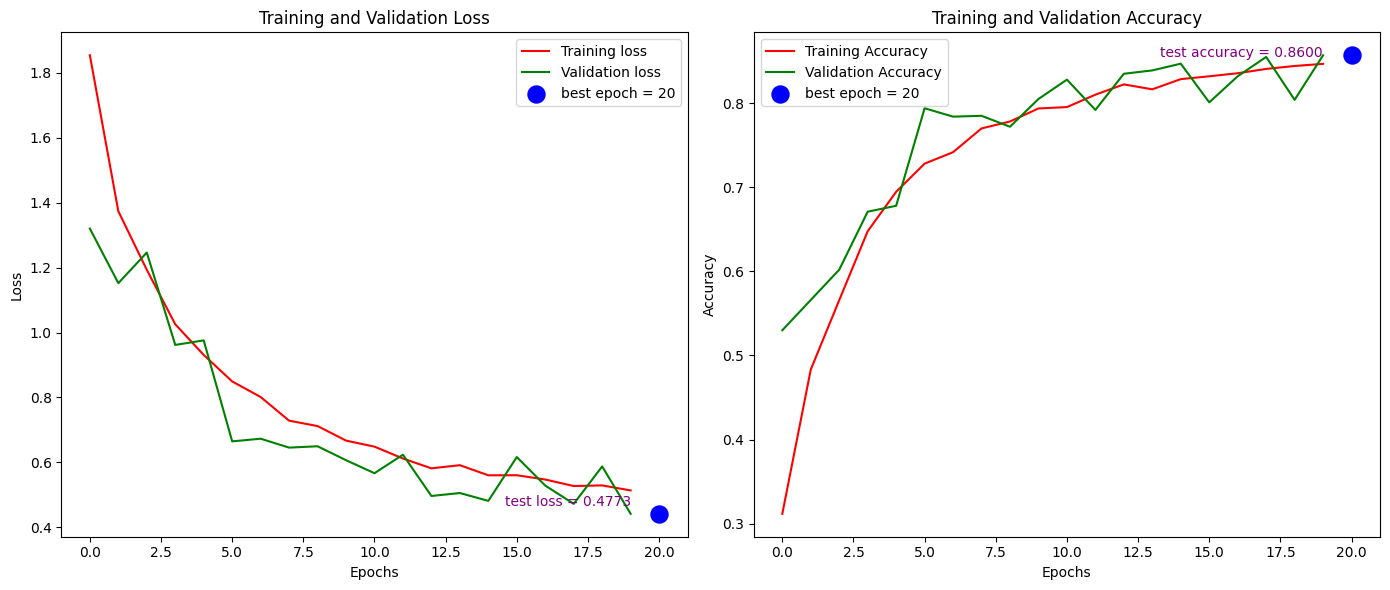

In [ ]:


# training and validation data
tacc = history4.history['accuracy']
tloss = history4.history['loss']
vacc = history4.history['val_accuracy']
vloss = history4.history['val_loss']

# get number of epochs and create list of epochs
Epoch_count = len(tacc) + 0
Epochs = list(range(0, 20))

# get best epoch based on validation loss and accuracy
index_loss = np.argmin(vloss)
val_lowest = vloss[index_loss]
index_acc = np.argmax(vacc)
acc_highest = vacc[index_acc]

# evaluate model on test set and get test loss and accuracy
test_loss, test_acc = model4.evaluate(test_generator)

# create labels for best epochs and test results
sc_label = 'best epoch = ' + str(index_loss + 1 + 0)
vc_label = 'best epoch = ' + str(index_acc + 1 + 0)
test_loss_label = 'test loss = {:.4f}'.format(test_loss)
test_acc_label = 'test accuracy = {:.4f}'.format(test_acc)

# create subplots for loss and accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# plot training and validation loss
axes[0].plot(Epochs, tloss, 'r', label='Training loss')
axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
axes[0].scatter(index_loss + 1 + 0, val_lowest, s=150, c='blue', label=sc_label)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# add test loss to the plot
axes[0].text(Epochs[-1], test_loss, test_loss_label, ha='right', va='center', color='purple')

# plot training and validation accuracy
axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
axes[1].scatter(index_acc + 1 + 0, acc_highest, s=150, c='blue', label=vc_label)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# add test accuracy to the plot
axes[1].text(Epochs[-1], test_acc, test_acc_label, ha='right', va='center', color='purple')

plt.tight_layout()
plt.show()


### Confusion matrix

1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       936
           1       0.83      0.96      0.89      1000
           2       0.88      0.78      0.83       906
           3       0.84      0.79      0.81       833
           4       0.91      0.94      0.93       987
           5       0.88      0.65      0.75       929
           6       0.82      0.88      0.85       953
           7       0.79      0.98      0.87      1064
           8       0.82      0.82      0.82      1073
           9       1.00      0.83      0.91       735

    accuracy                           0.86      9416
   macro avg       0.87      0.86      0.86      9416
weighted avg       0.87      0.86      0.86      9416

Confusion matrix, rakamsal olarak
[[ 869    0    0    0    0    9   30    0   28    0]
 [   0  963    0    0    0    9    0    9   19    0]
 [   0   27  710   10   37    0   37   67   18   

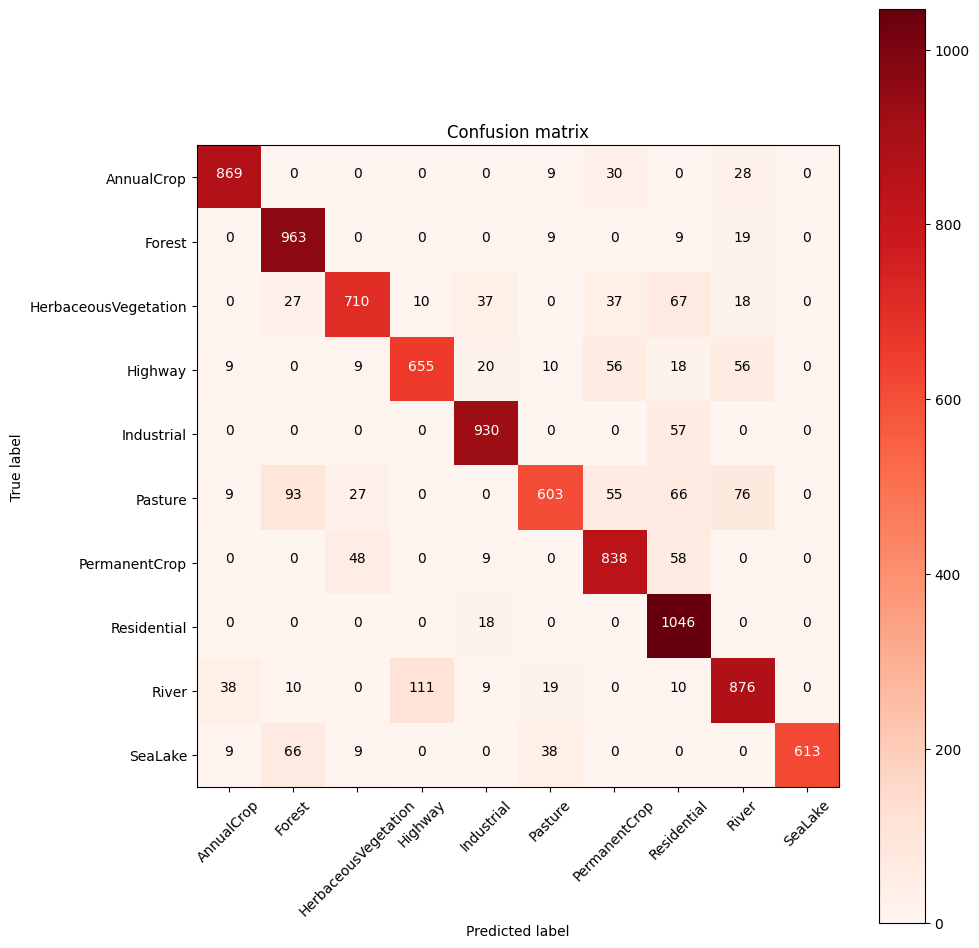

In [ ]:
cm4 = conf_matrix(test_generator, model4)
plot_confusion_matrix(cm4, test_generator.class_indices, cmap='Reds')

### Modelin görselleştirilmesi

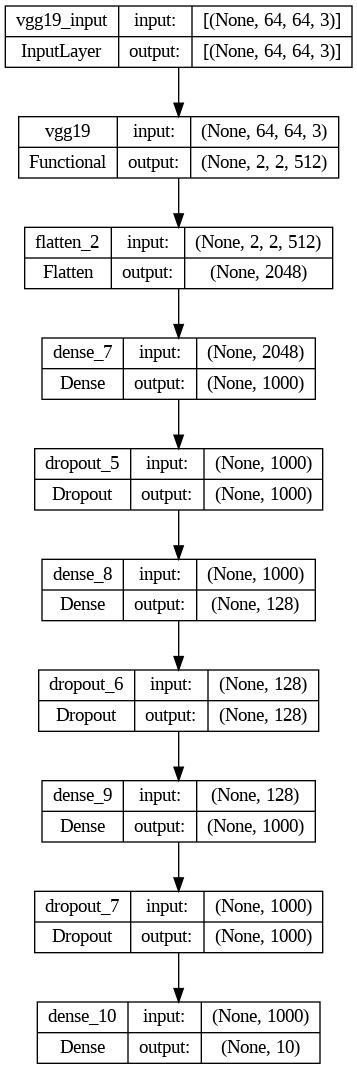

In [ ]:
tf.keras.utils.plot_model(model4, "vgg19_finetuning.png", show_shapes=True)

In [ ]:
!pip install visualkeras
import visualkeras

model = bestmodel_checkpoint4

visualkeras.layered_view(model).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

#visualkeras.layered_view(model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 53.7 MB/s eta 0:00:00
